## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [109]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# row/column display limit
pd.set_option('display.max_columns',None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [110]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [111]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [112]:
# Checking shape of dataframe
df.shape

(78313, 22)

In [113]:
# Inspecting column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [114]:
#print the column names
cols = df.columns.to_list()
print("Columns names:\n",cols)

Columns names:
 ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [115]:
# Checking null value counts for each column.
df.isnull().sum()

,0
_index,0
_type,0
_id,0
_score,0
_source.tags,67413
_source.zip_code,6757
_source.complaint_id,0
_source.issue,0
_source.date_received,0
_source.state,1991


In [116]:
#Assign new column names
cols_new = [re.sub('source.','',col[1:]) for col in cols]
print("New column names:\n",cols_new, "\n")

# Applying new column names
df.columns = cols_new
df.head()

New column names:
 ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'] 



,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


Our primary column of interest is "complaint_what_happened". There seem to be some blanks in this column as well, which would render these rows useless for our use. These rows may be deleted.

In [117]:
# Checking no. of null values in "complaints_what_happened" column.
df.complaint_what_happened.isnull().sum()

0

In [118]:
# Number of rows with blank complaints
print("No. of rows with blank complaints: ",len(df[(df.complaint_what_happened == "") | (df.complaint_what_happened == " ")]))

No. of rows with blank complaints:  57241


In [119]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r"^\s*$",np.NaN,regex=True)
print("No. of rows with nan in complaints column: ", df.complaint_what_happened.isnull().sum())

No. of rows with nan in complaints column:  57241


In [120]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

print("New shape of dataframe: ")
df.shape

New shape of dataframe: 


(21072, 22)

In [121]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [122]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'\[.*?\]', '', text)  # Remove text within square brackets
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [123]:
df['complaints_cleaned'] = df.complaint_what_happened.apply(text_preprocess)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it if...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the agen...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a ticket i came across...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...


In [124]:
#Write your function to Lemmatize the texts
def lemma_texts(text):

    # Initialize empty list to store lemmas
    lemma_list = []

    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [125]:
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_texts(x['complaints_cleaned']), axis=1)

In [126]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened', 'complaints_cleaned', 'lemmatized_complaint']]

In [127]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while try to book a ticket I come across an...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...


It is more likely the words of interest for Topic Modelling are nouns and proper nouns. Words with other POS tags are unlikely to be of much use to us. Hence, the code below creates a new column which includes only words with POS tags as nouns.

In [128]:
#Write your function to extract the POS tags
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm

pos_tags = []  # List to store POS tags of each lemmatized complaint
nouns = []     # List to store only the nouns from the complaint

for complaint in tqdm(df_clean.lemmatized_complaint):
    pos = ''
    noun = ''
    proc_complaint = nlp(complaint)
    for tok in proc_complaint:
        pos += tok.pos_ + ' '
        if tok.pos_ in str(('NOUN', 'PROPN')) :
            noun += (tok.lemma_.lower()) + ' '
    pos_tags.append(pos.strip())
    nouns.append(noun.strip())

100%|██████████| 21072/21072 [15:04<00:00, 23.30it/s]


In [129]:
df_clean['pos_tags_lemmatized'] = pd.Series(pos_tags, index=df_clean.index)
df_clean['complaints_nouns_only'] = pd.Series(nouns, index=df_clean.index)

#Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

In [130]:
#The clean dataframe should now contain the raw complaint, cleaned complaints, lemmatized complaint,
#pos tags of lemmatized complaints and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaint,pos_tags_lemmatized,complaints_nouns_only
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,ADJ NOUN PRON NOUN AUX CCONJ PRON VERB PRON SC...,morning name stop bank cardmember service ask ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,PRON VERB PRON NOUN ADP CCONJ AUX VERB ADP DET...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,NOUN NOUN AUX NOUN ADP ADV ADJ NOUN AUX AUX VE...,chase card report application identity consent...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ADP SCONJ VERB PART VERB DET NOUN PRON VERB AD...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRON ADJ NOUN VERB PRON VERB SCONJ PRON VERB P...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [131]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean.complaint_what_happened.str.len().sort_values(ascending=False).head(10)

,complaint_what_happened
436,31611
11241,31385
14251,29948
2308,29239
1130,25757
9031,25450
9467,23778
5880,22791
3924,22028
8799,21175


Text(0.5, 0, 'Character length ranges')

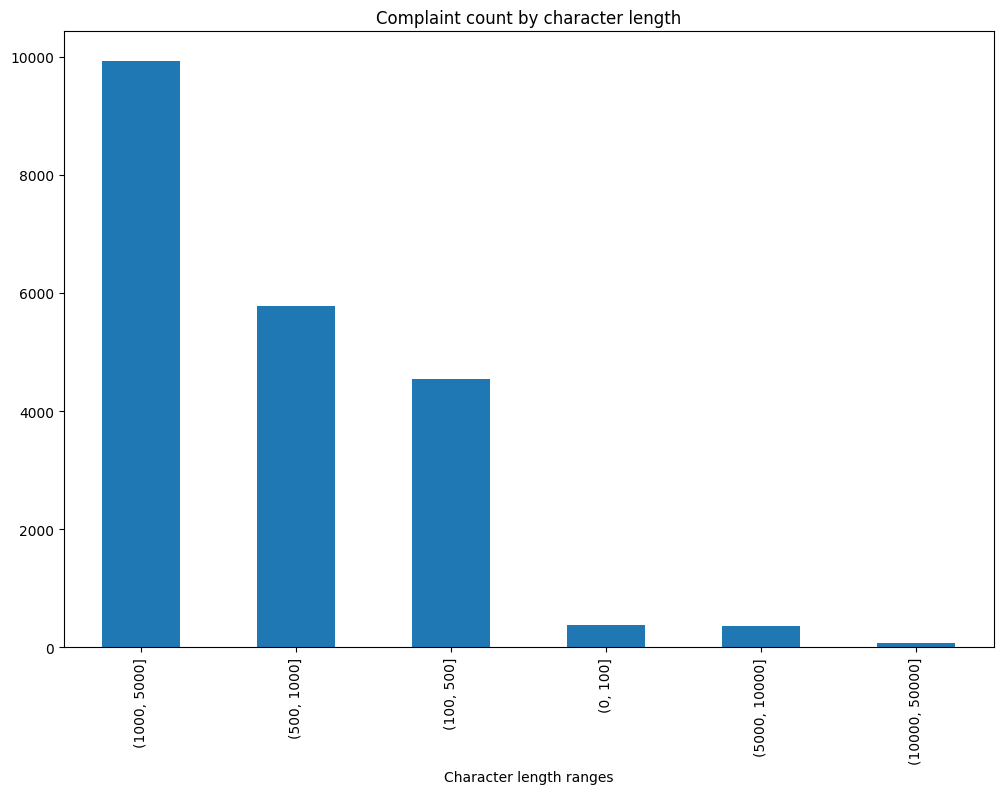

In [132]:
# Write your code here to visualise the data according to the 'Complaint' character length
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean.complaint_what_happened.str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Character length ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

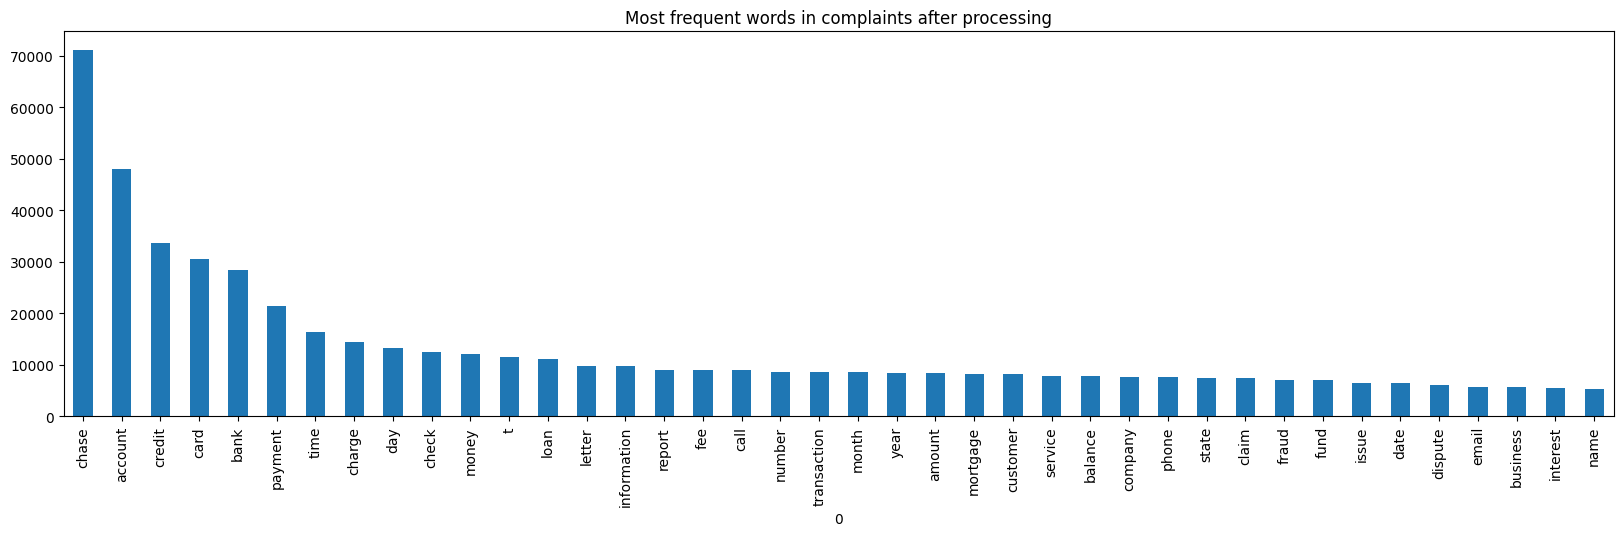

In [133]:
# Most frequent words in the processed (lemmatized) complaints
most_freq_lem=[] # List to extract most frequent words

for complaint in df_clean.complaints_nouns_only:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5))
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

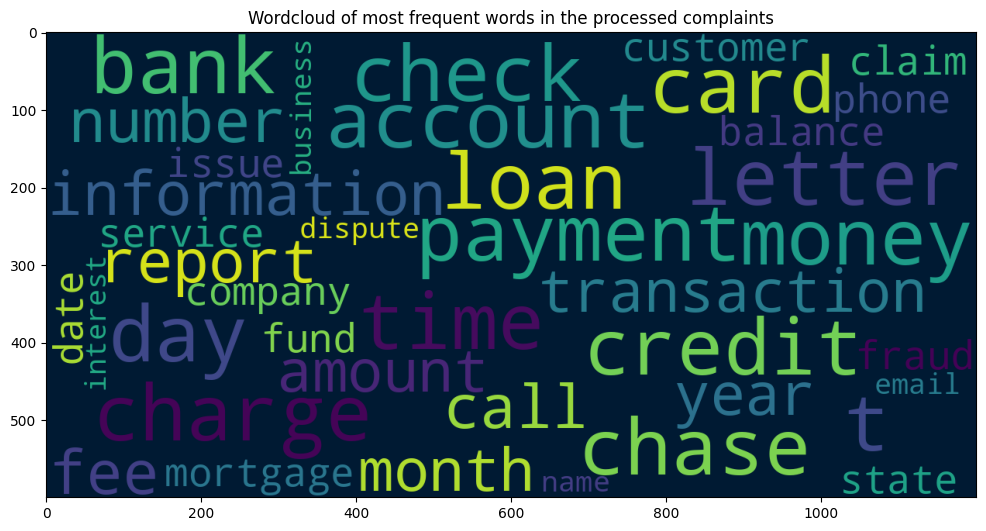

In [134]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = '#001a33', width = 1200, height = 600, colormap = 'viridis',
                      max_words = 40, contour_width = 3, max_font_size = 100, contour_color = 'steelblue',
                      random_state = 1,
                      stopwords=set(STOPWORDS))

most_freq_words = pd.DataFrame(most_freq_lem)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_words]))

plt.imshow(wordcloud)
plt.title("Wordcloud of most frequent words in the processed complaints")
plt.show()

In [135]:
#Removing -PRON- from the text corpus
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

df_clean['Complaint_clean'] = df_clean['complaints_nouns_only'].apply(
    lambda x: ' '.join([word for word, tag in nltk.pos_tag(nltk.word_tokenize(x)) if tag not in ['PRP', 'PRP$', 'PRON']])
)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [136]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaint,pos_tags_lemmatized,complaints_nouns_only,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,ADJ NOUN PRON NOUN AUX CCONJ PRON VERB PRON SC...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,PRON VERB PRON NOUN ADP CCONJ AUX VERB ADP DET...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,NOUN NOUN AUX NOUN ADP ADV ADJ NOUN AUX AUX VE...,chase card report application identity consent...,chase card report application identity consent...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ADP SCONJ VERB PART VERB DET NOUN PRON VERB AD...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRON ADJ NOUN VERB PRON VERB SCONJ PRON VERB P...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [137]:
# Importing required libraries.
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

In [138]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
word_vect = vectorizer.fit_transform(df_clean['complaints_nouns_only'])
freqs = sum(word_vect).toarray()[0]

unigram_df = pd.DataFrame(freqs, index=vectorizer.get_feature_names_out(), columns=['frequency'])

#Print the top 30 words in the unigram by frequency
print("Top 30 words in the unigram by frequency:")
unigram_df.sort_values(by="frequency", ascending = False).head(30)

Top 30 words in the unigram by frequency:


,frequency
chase,71134
account,47898
credit,33719
card,30539
bank,28299
payment,21357
time,16304
charge,14433
day,13321
check,12389


<Figure size 2000x500 with 0 Axes>

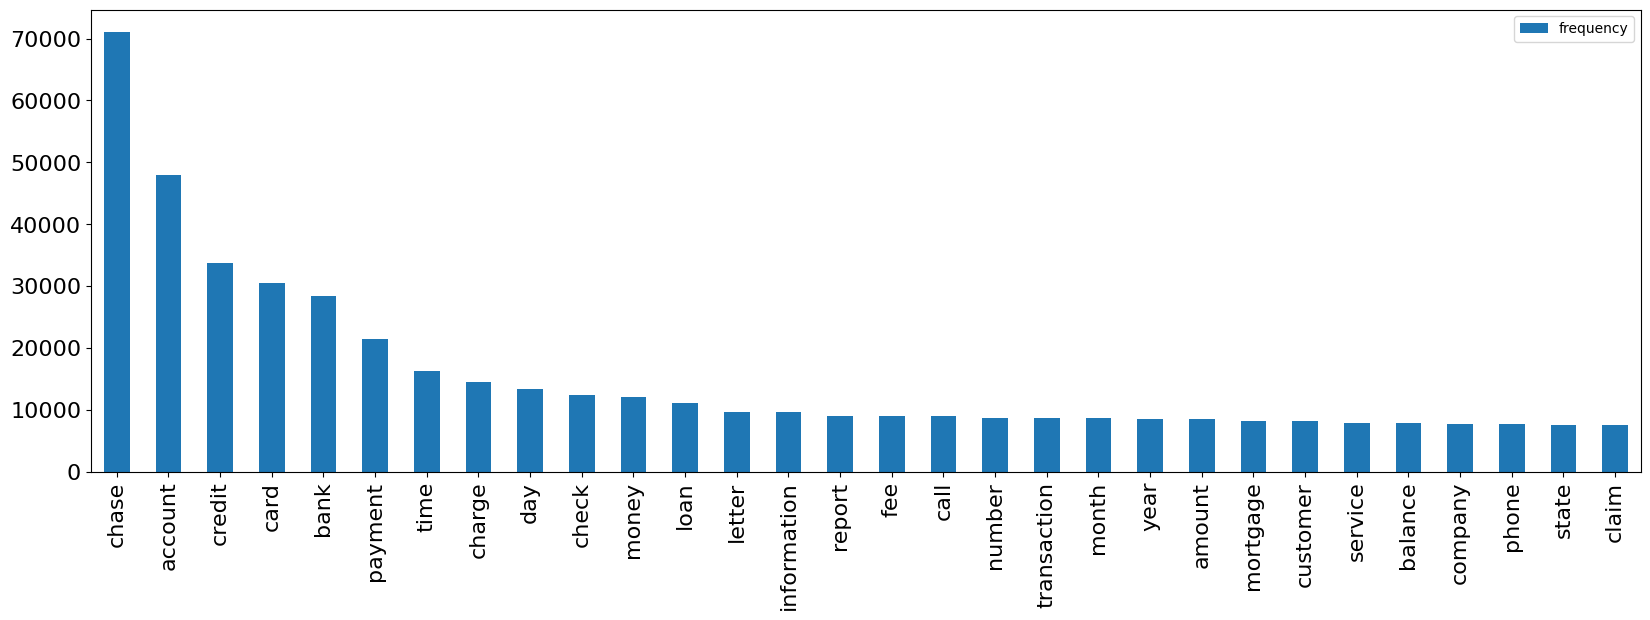

In [139]:
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(20, 5))
unigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [140]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), analyzer='word')
word_vector_bigram = vectorizer_bigram.fit_transform(df_clean['complaints_nouns_only'])
freqs_bigram = sum(word_vector_bigram).toarray()[0]

bigram_df = pd.DataFrame(freqs_bigram, index=vectorizer_bigram.get_feature_names_out(), columns=['frequency'])

Top 30 bigrams by frequency:
                  frequency
credit card           12923
chase bank            12160
account chase          3975
credit report          3963
customer service       3091
chase credit           3017
chase account          2877
bank account           2735
morgan chase           2559
jp morgan              2399
check account          2316
account account        2271
debit card             2061
checking account       1970
card chase             1955
chase card             1899
credit score           1715
phone call             1664
card account           1645
account credit         1474
payment payment        1369
interest rate          1310
money account          1302
business day           1273
letter chase           1272
phone number           1250
account number         1190
chase chase            1189
bank chase             1183
call chase             1134


<Figure size 2000x500 with 0 Axes>

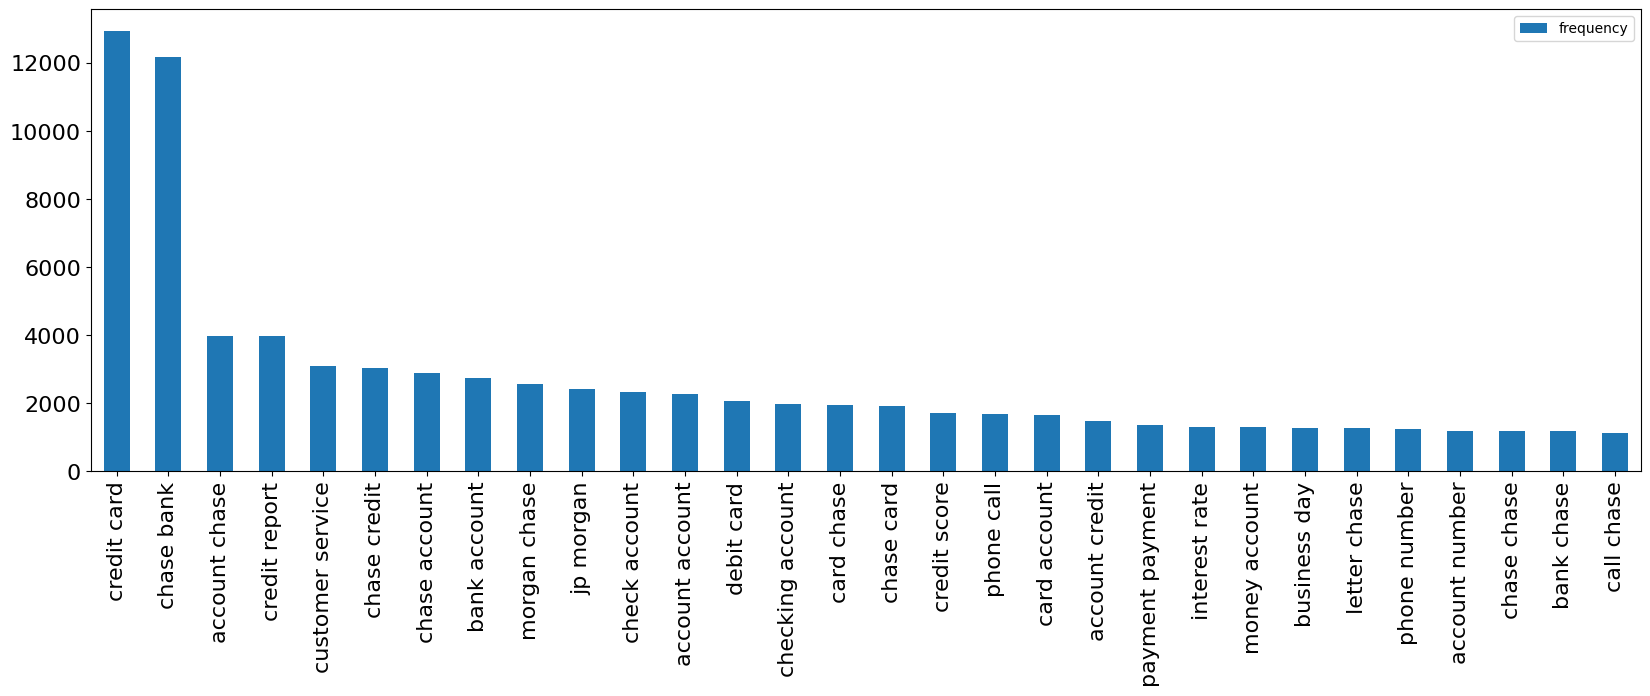

In [141]:
#Print the top 10 words in the bigram frequency
#Print thelemmatized_complaints 10 words in the bigram frequency
print("Top 30 bigrams by frequency:")
print(bigram_df.sort_values(by="frequency", ascending = False).head(30))

plt.figure(figsize=(20, 5))
bigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [142]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
vectorizer_trigram = CountVectorizer(ngram_range=(3,3), analyzer='word')
word_vector_trigram = vectorizer_trigram.fit_transform(df_clean['complaints_nouns_only'])
freqs_trigram = sum(word_vector_trigram).toarray()[0]

trigram_df = pd.DataFrame(freqs_trigram, index=vectorizer_trigram.get_feature_names_out(), columns=['frequency'])

Top 30 trigrams by frequency:
                                 frequency
jp morgan chase                       1990
chase credit card                     1987
credit card account                   1080
credit card company                    990
credit card chase                      955
account chase bank                     921
chase bank account                     792
morgan chase bank                      704
inquiry credit report                  519
credit card credit                     479
chase bank credit                      452
account credit card                    428
chase customer service                 427
chase checking account                 394
charge credit card                     389
credit reporting agency                384
bank credit card                       375
jpmorgan chase bank                    375
card credit card                       372
check account chase                    366
credit report credit                   357
card chase bank         

<Figure size 2000x500 with 0 Axes>

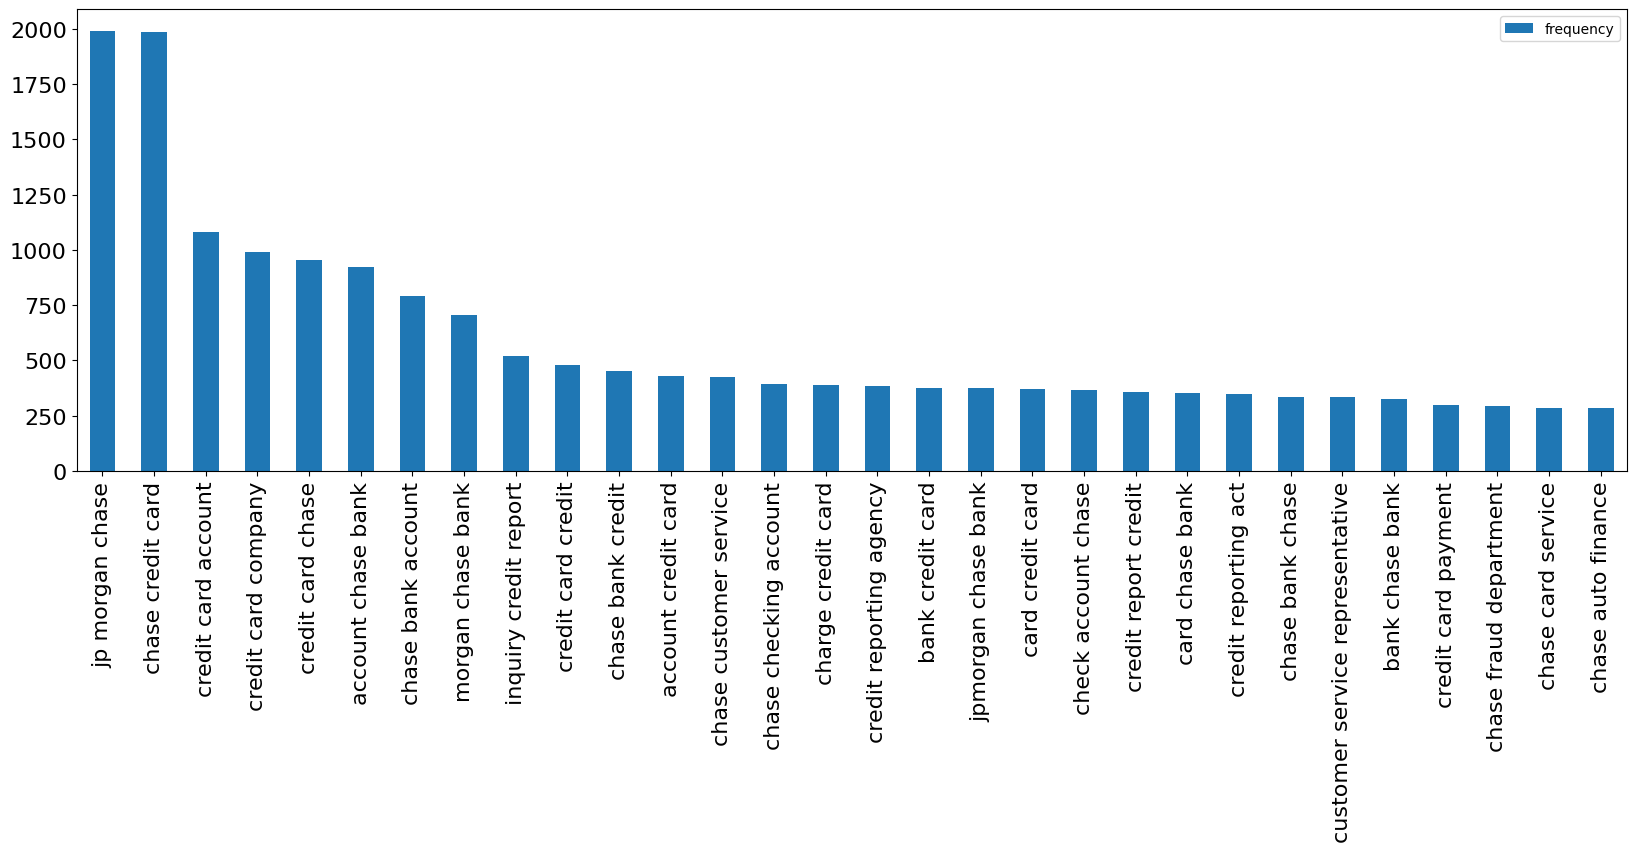

In [143]:
#Print the top 10 words in the trigram frequency
print("Top 30 trigrams by frequency:")
print(trigram_df.sort_values(by="frequency", ascending = False).head(30))

plt.figure(figsize=(20, 5))
trigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [144]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['lemmatized_complaint'] = df_clean['lemmatized_complaint'].str.replace('xxxx','')
df_clean['complaints_nouns_only'] = df_clean['complaints_nouns_only'].str.replace('xxxx','')

In [145]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaint,pos_tags_lemmatized,complaints_nouns_only,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,ADJ NOUN PRON NOUN AUX CCONJ PRON VERB PRON SC...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,PRON VERB PRON NOUN ADP CCONJ AUX VERB ADP DET...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,NOUN NOUN AUX NOUN ADP ADV ADJ NOUN AUX AUX VE...,chase card report application identity consent...,chase card report application identity consent...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ADP SCONJ VERB PART VERB DET NOUN PRON VERB AD...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRON ADJ NOUN VERB PRON VERB SCONJ PRON VERB P...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [146]:
#Write your code here to initialise the TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,           # Ignore terms that appear in fewer than 3 documents
    max_df=0.9,         # Ignore terms that appear in more than 90% of the documents
    max_features=5000,  # Keeping max_features to 5000 to keep within memory limits.
    ngram_range=(1, 3)  # Consider unigrams, bigrams, and trigrams
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [147]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['complaints_nouns_only'])
features = tfidf_vectorizer.get_feature_names_out()

# Creating a dataframe to display the document-term matrix created above
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
tfidf_df.head()

ability  abuse  acceptance  access  access account  access chase  \
0      0.0    0.0         0.0     0.0             0.0           0.0   
1      0.0    0.0         0.0     0.0             0.0           0.0   
2      0.0    0.0         0.0     0.0             0.0           0.0   
3      0.0    0.0         0.0     0.0             0.0           0.0   
4      0.0    0.0         0.0     0.0             0.0           0.0   

   access credit  access fund  access information  access money  accident  \
0            0.0          0.0                 0.0           0.0       0.0   
1            0.0          0.0                 0.0           0.0       0.0   
2            0.0          0.0                 0.0           0.0       0.0   
3            0.0          0.0                 0.0           0.0       0.0   
4            0.0          0.0                 0.0           0.0       0.0   

   accommodation  accord  accord credit  accordance   account  account access  \
0            0.0     0.0            0.0         0.0  0.060179             0.0   
1            0.0     0.0            0.0         0.0  0.061111             0.0   
2            0.0     0.0            0.0         0.0  0.000000             0.0   
3            0.0     0.0            0.0         0.0  0.098624             0.0   
4            0.0     0.0            0.0         0.0  0.085105             0.0   

   account accord  account account  account account account  \
0             0.0              0.0                      0.0   
1             0.0              0.0                      0.0   
2             0.0              0.0                      0.0   
3             0.0              0.0                      0.0   
4             0.0              0.0                      0.0   

   account account balance  account account chase  account account credit  \
0                      0.0                    0.0                     0.0   
1                      0.0                    0.0                     0.0   
2                      0.0                    0.0                     0.0   
3                      0.0                    0.0                     0.0   
4                      0.0                    0.0                     0.0   

   account account day  account account money  account account number  \
0                  0.0                    0.0                     0.0   
1                  0.0                    0.0                     0.0   
2                  0.0                    0.0                     0.0   
3                  0.0                    0.0                     0.0   
4                  0.0                    0.0                     0.0   

   account activity  account address  account agreement  account amount  \
0               0.0              0.0                0.0             0.0   
1               0.0              0.0                0.0             0.0   
2               0.0              0.0                0.0             0.0   
3               0.0              0.0                0.0             0.0   
4               0.0              0.0                0.0             0.0   

   account app  account atm  account attempt  account authorization  \
0          0.0          0.0              0.0                    0.0   
1          0.0          0.0              0.0                    0.0   
2          0.0          0.0              0.0                    0.0   
3          0.0          0.0              0.0                    0.0   
4          0.0          0.0              0.0                    0.0   

   account balance  account balance account  account balance chase  \
0              0.0                      0.0                    0.0   
1              0.0                      0.0                    0.0   
2              0.0                      0.0                    0.0   
3              0.0                      0.0                    0.0   
4              0.0                      0.0                    0.0   

   account bank  account bank account  account

In [148]:
tfidf_df.shape

(21072, 5000)

In [149]:
len(tfidf_vectorizer.get_feature_names_out())

5000

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [150]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [151]:
#Load your nmf_model with the n_components i.e 5
# Set the number of topics for NMF
num_topics = 5  # You can adjust this value as needed

# Initialize the NMF model with the specified number of topics and a fixed random_state
nmf_model = NMF(n_components=num_topics, random_state=40)

# Apply NMF to the TF-IDF matrix
W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

# Retrieve the feature names (terms) from the TF-IDF vectorizer
words = np.array(tfidf_vectorizer.get_feature_names_out())

# Initialize a DataFrame to hold the top 15 words for each topic
topic_words = pd.DataFrame(np.zeros((num_topics, 15)),
                           index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

# Fill the DataFrame with the top 15 words for each topic
for i in range(num_topics):
    top_words_idx = H[i].argsort()[::-1][:15]  # Get indices of the top 15 words for topic i
    topic_words.iloc[i] = words[top_words_idx]  # Assign the words to the DataFrame

# Display the top words for each topic
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,fund,chase bank,deposit,transaction,branch,day,claim,account chase,bank account,number
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,service,merchant,company,card chase,fraud,time
Topic 3,loan,mortgage,chase,home,modification,property,year,morgan,document,foreclosure,letter,time,sale,house,morgan chase
Topic 4,report,credit,inquiry,credit report,inquiry credit,inquiry credit report,account,report credit,debt,score,reporting,jpmcb,information,identity,credit score
Topic 5,payment,balance,fee,interest,month,payment payment,statement,payment chase,amount,chase payment,auto,chase,time,day,bill


In [152]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping_num = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}


In [153]:
# Convert the Document-Topic matrix (W) to a DataFrame with topic columns
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])

# Apply a function to determine the topic with the highest score for each row
def get_max_topic(row):
    max_topic_idx = row.idxmax()  # Get the index (topic) of the highest value
    return topic_mapping_num.get(max_topic_idx, '4')  # Use the mapping or default to '4'

# Apply the function to each row to create the 'max_topic' column
W['max_topic'] = W.apply(get_max_topic, axis=1)

# Display the top 10 rows where 'max_topic' is not null
W[W['max_topic'].notna()].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.018994,0.003268,0.014899,0.013728,0.005736,0
1,0.005941,0.014362,0.004342,0.001418,0.001322,1
2,0.000000,0.026233,0.000515,0.044244,0.000000,3
3,0.016599,0.019828,0.013516,0.065347,0.000000,3
4,0.059344,0.000000,0.005032,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.105245,0.000000,3
6,0.051823,0.004079,0.005537,0.000000,0.011366,0
7,0.002056,0.007370,0.042439,0.000000,0.051455,4
8,0.035016,0.023824,0.022001,0.006353,0.002706,0
9,0.000000,0.034750,0.000000,0.075288,0.000000,3


In [154]:
W['max_topic'].value_counts().sort_index()

,count
max_topic,
0,5923
1,6285
2,3862
3,2465
4,2537


In [155]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W['max_topic'].apply(lambda x:int(x))

In [156]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaint,pos_tags_lemmatized,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,ADJ NOUN PRON NOUN AUX CCONJ PRON VERB PRON SC...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,PRON VERB PRON NOUN ADP CCONJ AUX VERB ADP DET...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,NOUN NOUN AUX NOUN ADP ADV ADJ NOUN AUX AUX VE...,chase card report application identity consent...,chase card report application identity consent...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ADP SCONJ VERB PART VERB DET NOUN PRON VERB AD...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRON ADJ NOUN VERB PRON VERB SCONJ PRON VERB P...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [157]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample = df_clean.groupby('Topic').apply(lambda x: x.head(5)).reset_index(drop=True)

# Sort the sample DataFrame by 'Topic'
df_clean_sample = df_clean_sample.sort_values(by='Topic')

# Display the first 5 complaints for each topic
df_clean_sample

,complaint_what_happened,complaints_cleaned,lemmatized_complaint,pos_tags_lemmatized,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,ADJ NOUN PRON NOUN AUX CCONJ PRON VERB PRON SC...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRON ADJ NOUN VERB PRON VERB SCONJ PRON VERB P...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
2,With out notice J.P. Morgan Chase restricted m...,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restrict my a...,ADP ADP NOUN PROPN PROPN PROPN PROPN VERB PRON...,notice j p morgan chase account debit card tue...,notice j p morgan chase account debit card tue...,0
3,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on i made a payment to an online retailer usin...,on I make a payment to an online retailer use ...,ADV PRON VERB DET NOUN ADP DET ADJ NOUN VERB N...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
4,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and,mishandle of this account by chase auto and,NOUN ADP DET NOUN ADP NOUN NOUN CCONJ,mishandle account chase auto,mishandle account chase auto,0
5,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,PRON VERB PRON NOUN ADP CCONJ AUX VERB ADP DET...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
6,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,PRON NOUN PROPN NOUN AUX NOUN ADP DET NOUN NOU...,chase amazon card decline catering order place...,chase amazon card decline catering order place...,1
7,"XXXX XXXX a sofa, love seat, table and chairs ...",a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and be neve...,SPACE DET NOUN NOUN NOUN NOUN CCONJ NOUN CCONJ...,sofa love seat table chair debit card charge b...,sofa love seat table chair debit card charge b...,1
8,I made a purchase with XXXX XXXX XXXX on XX/XX...,i made a purchase with on in the amount of i w...,I make a purchase with on in the amount of I b...,PRON VERB DET NOUN ADP ADP ADP DET NOUN ADP PR...,purchase amount charge transaction dispute cas...,purchase amount charge transaction dispute cas...,1
9,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,PRON VERB DET ADJ NOUN PRON AUX VERB NOUN ADP ...,citizen scamme company time share company refu...,citizen scamme company time share company refu...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [158]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Banking Services",
    1: "Credit and Prepaid Cards",
    2: "Loans and Mortgages",
    3: "Fraud and Dispute resolution",
    4: "Others"
}

# Replace numeric Topic labels with their corresponding names using `replace()`
df_clean['Topic'] = df_clean['Topic'].replace(Topic_names)

In [159]:
df_clean.Topic.value_counts()

,count
Topic,
Credit and Prepaid Cards,6285
Banking Services,5923
Loans and Mortgages,3862
Others,2537
Fraud and Dispute resolution,2465


In [160]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaint,pos_tags_lemmatized,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,ADJ NOUN PRON NOUN AUX CCONJ PRON VERB PRON SC...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Banking Services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,PRON VERB PRON NOUN ADP CCONJ AUX VERB ADP DET...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit and Prepaid Cards
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,NOUN NOUN AUX NOUN ADP ADV ADJ NOUN AUX AUX VE...,chase card report application identity consent...,chase card report application identity consent...,Fraud and Dispute resolution
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ADP SCONJ VERB PART VERB DET NOUN PRON VERB AD...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Fraud and Dispute resolution
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRON ADJ NOUN VERB PRON VERB SCONJ PRON VERB P...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Banking Services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [161]:
#Create the dictionary again of Topic names and Topics

topic_labels = {
    "Banking Services": 0,
    "Credit and Prepaid Cards": 1,
    "Loans and Mortgages": 2,
    "Fraud and Dispute resolution": 3,
    "Others": 4
}

# Replace Topic names with corresponding numeric labels
df_clean['Topic'] = df_clean['Topic'].map(topic_labels)

In [162]:
df_clean.head()

,complaint_what_happened,complaints_cleaned,lemmatized_complaint,pos_tags_lemmatized,complaints_nouns_only,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,ADJ NOUN PRON NOUN AUX CCONJ PRON VERB PRON SC...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,PRON VERB PRON NOUN ADP CCONJ AUX VERB ADP DET...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,NOUN NOUN AUX NOUN ADP ADV ADJ NOUN AUX AUX VE...,chase card report application identity consent...,chase card report application identity consent...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ADP SCONJ VERB PART VERB DET NOUN PRON VERB AD...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRON ADJ NOUN VERB PRON VERB SCONJ PRON VERB P...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [163]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.loc[:, ["complaint_what_happened", "Topic"]]

In [164]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [165]:
training_data.head()

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",3
4,my grand son give me check for {$1600.00} i de...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [166]:

#Write your code to get the Vector count
vectorizer = CountVectorizer(
    ngram_range=(1, 3),        # Unigrams, bigrams, and trigrams
    stop_words='english',      # Remove English stop words
    max_df=0.95,               # Ignore terms that appear in more than 95% of the documents
    min_df=0.02                # Ignore terms that appear in less than 2% of the documents
)

# Fit and transform the complaint data to get the word count matrix
vector = vectorizer.fit_transform(training_data['complaint_what_happened'])

# Convert the sparse matrix to an array and print the result
vector_array = vector.toarray()
print(vector_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [6 0 0 ... 1 1 0]
 [2 0 0 ... 3 1 0]]


In [167]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize the TfidfTransformer with 'use_idf=True' to use Inverse Document Frequency weighting
tfidf_transformer = TfidfTransformer(use_idf=True)

# Fit the transformer to the word count vector and transform the vector to TF-IDF scores
word_vect = tfidf_transformer.fit_transform(vector)

# Output the shape of the resulting sparse matrix
print(word_vect.shape)

(21072, 883)


In [168]:
# Creating a dataframe of the tf-idf vector for use in model training.
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=vectorizer.get_feature_names_out(),index=training_data.index)
word_vect_df.head()

,00,00 account,00 chase,00 xx,00 xx xx,00 xxxx,00 xxxx xxxx,10,10 days,100,100 00,1000,1000 00,12,15,18,19,20,200,200 00,2000,2000 00,2015,2016,2017,2018,2019,2020,24,30,30 days,50,500,500 00,60,90,ability,able,absolutely,accept,accepted,access,according,account,account chase,account chase bank,account closed,account number,account xx,account xx xx,account xxxx,account xxxx xxxx,accounts,act,action,actions,activity,actually,add,added,addition,additional,address,advised,agencies,agency,agent,ago,agreed,agreement,alert,allow,allowed,amazon,amounts,annual,answer,app,apparently,appears,application,applied,apply,approval,approved,approximately,ask,asked,asking,assist,assistance,assured,atm,attached,attempt,attempted,attempts,attorney,authorization,authorize,authorized,auto,available,avoid,aware,away,bad,balance,bank,bank account,bank chase,bank xx,bank xx xx,bank xxxx,bank xxxx xxxx,banker,banking,bankruptcy,banks,based,began,beginning,behalf,believe,best,better,billing,bills,bonus,branch,branch manager,branch xxxx,bureau,bureaus,business,business days,buy,ca,called,called chase,called xxxx,called xxxx xxxx,calling,calls,came,cancel,cancelled,car,card,card account,card chase,card company,card xx,card xx xx,card xxxx,cards,care,case,cash,cause,caused,causing,cfpb,change,changed,charge,charged,charges,charging,chase,chase account,chase bank,chase bank xxxx,chase branch,chase card,chase chase,chase checking,chase closed,chase credit,chase credit card,chase customer,chase customer service,chase did,chase freedom,chase mortgage,chase representative,chase said,chase sent,chase told,chase xx,chase xx xx,chase xxxx,chase xxxx xxxx,check,check xxxx,checked,checking,checking account,checks,claim,claimed,claiming,claims,clear,cleared,clearly,close,close account,closed,closed account,closing,code,collect,collection,come,communication,companies,company,complaint,complaint chase,complaints,complete,completed,completely,concern,confirm,confirmation,confirmed,consumer,consumers,contact,contact chase,contacted,contacted chase,contacted xxxx,contacting,continue,continued,contract,conversation,copies,copy,correct,correspondence,cost,couple,course,court,cover,covid,credit,credit account,credit bureaus,credit card,credit card account,credit card chase,credit card company,credit cards,credit report,credit reporting,credit reports,credit score,credited,current,currently,customer,customer service,customers,date,date xx,date xx xx,dated,dated xx,dated xx xx,dates,day,days,days later,deal,debit,debit card,debt,decided,decision,declined,denied,department,deposit,deposited,deposits,dept,despite,details,did,did receive,didn,didnt,different,direct,directly,discovered,dispute,disputed,document,documentation,documents,does,doing,dollars,don,dont,early,email,emailed,emails,employee,employees,end,ended,ending,ending xxxx,entire,error,escrow,evidence,executive,executive office,explain,explained,explanation,extra,extremely,fact,failed,fair,false,family,far,fault,fax,federal,fee,feel,fees,file,filed,filing,final,finally,finance,financial,fine,fix,fixed,follow,followed,following,forced,foreclosure,form,forward,fraud,fraud department,fraudulent,free,freedom,friday,funds,future,gave,getting,given,giving,going,gone,good,got,government,happen,happened,hard,having,hear,heard,held,help,high,higher,history,hold,holder,holding,home,honor,hour,hours,house,husband,id,idea,identity,identity theft,illegal,im,immediately,included,including,income,incorrect,indicated,info,inform,information,informed,initial,initially,initiated,inquiries,inquiry,instead,institution,insurance,investigate,investigation,involved,issue,issued,issues,item,items,job,jp,jp morgan,jp morgan chase,jpmorgan,jpmorgan chase,just,kept,kind,knew,know,knowledge,lack,large,late,late fees,late payment,later,law,leave,left,legal,lender,let,let know,letter,letter chase,letters,life,like,limit,line,listed,little,live,loan,loan modification,loan xxxx,loans,local,located,location,long,longer,look,looked,looking,loss,lost,

In [169]:
#We have 883 features being used for our training.
features = vectorizer.get_feature_names_out()
print(features)

['00' '00 account' '00 chase' '00 xx' '00 xx xx' '00 xxxx' '00 xxxx xxxx'
 '10' '10 days' '100' '100 00' '1000' '1000 00' '12' '15' '18' '19' '20'
 '200' '200 00' '2000' '2000 00' '2015' '2016' '2017' '2018' '2019' '2020'
 '24' '30' '30 days' '50' '500' '500 00' '60' '90' 'ability' 'able'
 'absolutely' 'accept' 'accepted' 'access' 'according' 'account'
 'account chase' 'account chase bank' 'account closed' 'account number'
 'account xx' 'account xx xx' 'account xxxx' 'account xxxx xxxx'
 'accounts' 'act' 'action' 'actions' 'activity' 'actually' 'add' 'added'
 'addition' 'additional' 'address' 'advised' 'agencies' 'agency' 'agent'
 'ago' 'agreed' 'agreement' 'alert' 'allow' 'allowed' 'amazon' 'amounts'
 'annual' 'answer' 'app' 'apparently' 'appears' 'application' 'applied'
 'apply' 'approval' 'approved' 'approximately' 'ask' 'asked' 'asking'
 'assist' 'assistance' 'assured' 'atm' 'attached' 'attempt' 'attempted'
 'attempts' 'attorney' 'authorization' 'authorize' 'authorized' 'auto'
 'av

In [170]:
# Assigning our target variable to the word vector dataframe
word_vect_df["Topic"] = training_data["Topic"]

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [171]:
# Write your code here to build any 3 models and evaluate them using the required metrics





In [172]:
#Train - Test split

from sklearn.model_selection import train_test_split

X= word_vect_df.drop(['Topic'], axis=1)
y= word_vect_df['Topic']

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=40, stratify=y)

In [174]:
from sklearn import metrics

def evaluate_model(y_actual, y_pred):
    # Calculate the confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)

    # Calculate the accuracy score
    accuracy = metrics.accuracy_score(y_actual, y_pred)

    # Generate the classification report
    clf_report = metrics.classification_report(y_actual, y_pred)

    # Print the evaluation results
    print(f"Accuracy: {accuracy}")
    print("\nConfusion Matrix:")
    print(confusion)
    print("\nClassification Report:")
    print(clf_report)

    return accuracy

###Logistic Regression



In [175]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred=logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [176]:
lr_train_accuracy = evaluate_model(y_train.values,y_train_pred)

Accuracy: 0.9622247532270312

Confusion Matrix:
[[4347   51   24   11    9]
 [  51 4610   16   26   11]
 [  49   37 2788   12   10]
 [  27   67   21 1722   12]
 [  56   53   44   10 1740]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4442
           1       0.96      0.98      0.97      4714
           2       0.96      0.96      0.96      2896
           3       0.97      0.93      0.95      1849
           4       0.98      0.91      0.94      1903

    accuracy                           0.96     15804
   macro avg       0.96      0.95      0.96     15804
weighted avg       0.96      0.96      0.96     15804



In [177]:
lr_test_acc = evaluate_model(y_test.values,y_pred)

Accuracy: 0.9381169324221716

Confusion Matrix:
[[1420   32   19    5    5]
 [  36 1509    5   11   10]
 [  31   20  898    7   10]
 [  13   21   15  560    7]
 [  25   27   24    3  555]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1481
           1       0.94      0.96      0.95      1571
           2       0.93      0.93      0.93       966
           3       0.96      0.91      0.93       616
           4       0.95      0.88      0.91       634

    accuracy                           0.94      5268
   macro avg       0.94      0.93      0.93      5268
weighted avg       0.94      0.94      0.94      5268



###Decision Tree Classifier

In [178]:
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
tree = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=40)

In [179]:
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

In [180]:
tree_train_acc = evaluate_model(y_train.values,y_train_pred_tree)

Accuracy: 0.8237155150594786

Confusion Matrix:
[[3644  250  355   75  118]
 [ 359 3737  291  220  107]
 [ 143   81 2479   79  114]
 [  55  106  121 1529   38]
 [  57   53  126   38 1629]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4442
           1       0.88      0.79      0.84      4714
           2       0.74      0.86      0.79      2896
           3       0.79      0.83      0.81      1849
           4       0.81      0.86      0.83      1903

    accuracy                           0.82     15804
   macro avg       0.81      0.83      0.82     15804
weighted avg       0.83      0.82      0.82     15804



In [181]:
tree_test_acc = evaluate_model(y_test.values,y_test_pred_tree)

Accuracy: 0.7830296127562643

Confusion Matrix:
[[1146   97  131   43   64]
 [ 142 1206   99   77   47]
 [  68   30  777   34   57]
 [  20   40   50  493   13]
 [  20   29   67   15  503]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1481
           1       0.86      0.77      0.81      1571
           2       0.69      0.80      0.74       966
           3       0.74      0.80      0.77       616
           4       0.74      0.79      0.76       634

    accuracy                           0.78      5268
   macro avg       0.77      0.79      0.78      5268
weighted avg       0.79      0.78      0.78      5268



###Hyperparameter Tuning for Decision Tree

In [182]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Define cross-validation strategy
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=40, class_weight="balanced")

# Define hyperparameters for GridSearchCV
params_dt = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [5, 10, 20, 50]
}

# Perform GridSearchCV with DecisionTreeClassifier
dt_cv = GridSearchCV(estimator=dt, param_grid=params_dt, scoring='accuracy',
                     cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

# Fit the model with training data
dt_cv.fit(X_train, y_train)

# Extract the results from the cross-validation process
dt_cv_results = pd.DataFrame(dt_cv.cv_results_)

# Print the best parameters from the GridSearch
print("Best Parameters:", dt_cv.best_params_)

# Display the full GridSearch results
dt_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': 40, 'min_samples_leaf': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.819079,0.678068,0.035091,0.010768,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.701044,0.708637,0.706422,0.700411,0.706013,0.704505,0.003217,14,0.714546,0.717868,0.709009,0.728150,0.725641,0.719043,0.007053
1,1.449878,0.031784,0.018352,0.000872,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.701677,0.708320,0.707055,0.700411,0.705696,0.704632,0.003071,13,0.714150,0.718026,0.708693,0.727913,0.724692,0.718695,0.006958
2,1.419452,0.012136,0.017822,0.000907,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.700411,0.707687,0.706738,0.697248,0.703481,0.703113,0.003896,15,0.713043,0.716365,0.707427,0.726647,0.722003,0.717097,0.006719
3,1.837827,0.431206,0.023051,0.004817,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.697564,0.702309,0.708953,0.696299,0.702532,0.701531,0.004468,16,0.707506,0.711540,0.708060,0.720161,0.718760,0.713205,0.005310
4,3.891632,0.867110,0.026688,0.011694,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.765264,0.782664,0.786776,0.780766,0.776899,0.778474,0.007331,7,0.835008,0.839120,0.837855,0.839041,0.831778,0.836560,0.002817
5,2.308659,0.021530,0.017534,0.000398,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.765581,0.783613,0.783613,0.779500,0.777848,0.778031,0.006626,8,0.824171,0.824804,0.825358,0.825674,0.820785,0.824158,0.001763
6,3.571493,0.837205,0.031281,0.004165,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.756723,0.780133,0.778235,0.774122,0.771519,0.772146,0.008283,9,0.809064,0.807641,0.808036,0.810567,0.801961,0.807454,0.002927
7,2.658842,0.880839,0.021691,0.009435,10,50,"{'max_depth': 10, 'min_samples_leaf': 50}",0.758937,0.778235,0.771908,0.750712,0.767089,0.765376,0.009669,12,0.781618,0.790714,0.782330,0.776793,0.788358,0.783963,0.004989
8,4.681624,1.426990,0.027934,0.007487,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.783613,0.797532,0.789307,0.798165,0.790506,0.791825,0.005446,2,0.896227,0.892510,0.896306,0.890532,0.898054,0.894726,0.002769
9,4.288670,1.181686,0.021899,0.008317,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.774755,0.798165,0.788358,0.798481,0.794620,0.790876,0.008846,3,0.862849,0.862691,0.867120,0.859606,0.865074,0.863468,0.002523


In [183]:
#Using the best parameters
dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(X_train,y_train)

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

In [184]:
dt_train_acc = evaluate_model(y_train.values,y_train_pred_dt)

Accuracy: 0.8651607188053657

Confusion Matrix:
[[3773  191  233  102  143]
 [ 181 4028  153  221  131]
 [ 103   61 2507   93  132]
 [  24   61   55 1671   38]
 [  35   40   93   41 1694]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      4442
           1       0.92      0.85      0.89      4714
           2       0.82      0.87      0.84      2896
           3       0.79      0.90      0.84      1849
           4       0.79      0.89      0.84      1903

    accuracy                           0.87     15804
   macro avg       0.85      0.87      0.86     15804
weighted avg       0.87      0.87      0.87     15804



In [185]:
dt_test_acc = evaluate_model(y_test.values,y_test_pred_dt)

Accuracy: 0.798215641609719

Confusion Matrix:
[[1132  106  102   59   82]
 [  88 1274   62   95   52]
 [  60   43  762   40   61]
 [  15   25   32  528   16]
 [  20   26   60   19  509]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1481
           1       0.86      0.81      0.84      1571
           2       0.75      0.79      0.77       966
           3       0.71      0.86      0.78       616
           4       0.71      0.80      0.75       634

    accuracy                           0.80      5268
   macro avg       0.78      0.80      0.79      5268
weighted avg       0.81      0.80      0.80      5268



###Random Forest

In [186]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

# Define cross-validation strategy
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Define hyperparameters for GridSearchCV
params_rf = {
    'max_depth': [2, 5, 10],
    'min_samples_leaf': [50, 100, 200],
    'max_features': [8, 10],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV with RandomForestClassifier
rf_cv = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='accuracy',
                     cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

# Fit the model with training data
rf_cv.fit(X_train, y_train)

# Extract the results from the cross-validation process
rf_cv_results = pd.DataFrame(rf_cv.cv_results_)

# Print the best parameters from the GridSearch
print("Best Parameters:", rf_cv.best_params_)

# Display the full GridSearch results
rf_cv_results

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.999734,0.092927,0.092232,0.024364,2,8,50,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.753875,0.754192,0.752926,0.743436,0.740823,0.749050,0.005726,49,0.755517,0.753302,0.762635,0.754805,0.754666,0.756185,0.003304
1,1.345747,0.449067,0.082878,0.029947,2,8,50,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.803543,0.796900,0.794369,0.793420,0.787658,0.795178,0.005162,37,0.802974,0.796093,0.802341,0.806138,0.806311,0.802771,0.003707
2,1.646574,0.013640,0.115275,0.007166,2,8,50,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.795951,0.795318,0.786776,0.786460,0.778797,0.788660,0.006374,39,0.797675,0.792454,0.793087,0.795381,0.797849,0.795289,0.002242
3,0.482004,0.028634,0.047129,0.009019,2,8,100,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.753559,0.752610,0.753243,0.743436,0.741139,0.748797,0.005373,50,0.753935,0.751720,0.763347,0.754568,0.755141,0.755742,0.003975
4,1.200676,0.262882,0.087604,0.015288,2,8,100,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.804492,0.796583,0.795318,0.793420,0.789241,0.795811,0.005002,36,0.802658,0.794748,0.802341,0.805110,0.804888,0.801949,0.003772
5,3.077271,0.587344,0.134389,0.030213,2,8,100,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.795951,0.795951,0.785511,0.785511,0.779747,0.788534,0.006411,40,0.796488,0.791584,0.791189,0.793245,0.797453,0.793992,0.002547
6,0.510626,0.024758,0.041654,0.002624,2,8,200,50,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.737109,0.742803,0.739639,0.729200,0.731646,0.736079,0.005019,51,0.735506,0.741992,0.751641,0.748003,0.744859,0.744400,0.005487
7,0.870100,0.033242,0.063029,0.005794,2,8,200,100,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.792154,0.792471,0.784878,0.784878,0.783544,0.787585,0.003892,41,0.792533,0.790793,0.790398,0.797200,0.798481,0.793881,0.003337
8,1.745660,0.240516,0.109541,0.015405,2,8,200,200,"{'max_depth': 2, 'max_features': 8, 'min_sampl...",0.788674,0.789940,0.776020,0.772857,0.774367,0.780372,0.007375,43,0.787155,0.783279,0.778692,0.787155,0.786539,0.784564,0.003270
9,0.945047,0.102155,0.072273,0.011966,2,10,50,50,"{'max_depth': 2, 'max_features': 10, 'min_samp...",0.728567,0.736159,0.725720,0.716862,0.713608,0.724183,0.008130,52,0.726647,0.731630,0.732263,0.732896,0.741617,0.733010,0.004838


In [187]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=10,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [188]:
rf_best.fit(X_train,y_train)

y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [189]:
rf_train_acc = evaluate_model(y_train.values,y_train_pred_rf)

Accuracy: 0.8558592761326247

Confusion Matrix:
[[4063  115   74  135   55]
 [ 350 3906   47  288  123]
 [ 141   68 2455  153   79]
 [  19   39   29 1732   30]
 [ 148  106  183   96 1370]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      4442
           1       0.92      0.83      0.87      4714
           2       0.88      0.85      0.86      2896
           3       0.72      0.94      0.81      1849
           4       0.83      0.72      0.77      1903

    accuracy                           0.86     15804
   macro avg       0.84      0.85      0.84     15804
weighted avg       0.86      0.86      0.86     15804



In [190]:
rf_test_acc = evaluate_model(y_test.values,y_test_pred_rf)

Accuracy: 0.8428246013667426

Confusion Matrix:
[[1336   43   34   48   20]
 [ 124 1284   22   90   51]
 [  59   28  802   48   29]
 [   5   18   11  572   10]
 [  43   51   59   35  446]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1481
           1       0.90      0.82      0.86      1571
           2       0.86      0.83      0.85       966
           3       0.72      0.93      0.81       616
           4       0.80      0.70      0.75       634

    accuracy                           0.84      5268
   macro avg       0.83      0.84      0.83      5268
weighted avg       0.85      0.84      0.84      5268



###Summary of all three models

In [191]:
# Creating a summary DataFrame for model results with appropriate metrics for each model
model_names = ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier']
train_accuracies = [lr_train_accuracy, dt_train_acc, rf_train_acc]
test_accuracies = [lr_test_acc, dt_test_acc, rf_test_acc]

# Create a dictionary and convert it into a DataFrame
summary_dict = {
    "Training Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies
}

summary_df = pd.DataFrame(summary_dict, index=model_names)

# Display the summary DataFrame
summary_df

,Training Accuracy,Test Accuracy
Logistic Regression,0.962225,0.938117
Decision Tree Classifier,0.865161,0.798216
Random Forest Classifier,0.855859,0.842825


###Model Inference

We can conclude that the standard logistic regression model performs the best for our use case, with no significant overfitting to be concerned about. Next, we can evaluate the model's performance by testing it with custom texts.

In [192]:
print(Topic_names)

{0: 'Banking Services', 1: 'Credit and Prepaid Cards', 2: 'Loans and Mortgages', 3: 'Fraud and Dispute resolution', 4: 'Others'}


In [193]:
# Function to predict the topic for a custom complaint text using a given model
def predict_complaint(sentence, model=logreg, vectorizer=vectorizer, tfidf_transformer=tfidf_transformer, topic_names=Topic_names):
    # Vectorizing the custom text using the same vectorizer that was used during model training
    vect_custom = vectorizer.transform(pd.Series(sentence))
    word_vect_custom = tfidf_transformer.transform(vect_custom)

    # Converting the vectorized text into a DataFrame
    word_vect_custom_df = pd.DataFrame(word_vect_custom.toarray(), columns=vectorizer.get_feature_names_out())

    # Making the prediction
    custom_pred = model.predict(word_vect_custom_df)

    # Printing the predicted output
    predicted_topic_num = custom_pred[0]
    predicted_topic_name = topic_names.get(predicted_topic_num, "Unknown")

    print(f"The complaint is classified under topic number {predicted_topic_num}, which corresponds to: {predicted_topic_name}")

# Custom complaint text samples
text1 = "I noticed an unauthorized charge of $500 on my credit card statement. I have already reported it to the bank, but I have not received a resolution yet. The charge was made at an unfamiliar merchant, and I need assistance in disputing this charge and getting my account corrected."
predict_complaint(text1)

text2 = "I am writing to apply for a loan of $25,000 to expand my small business. My business has been running for 3 years, and I believe this loan will help us grow. I have all the necessary financial documents ready for your review. Please let me know how I can proceed with the application."
predict_complaint(text2)

text3 = "I want to switch my savings account to a current account that offers a no-balance option. Could you please inform me of the steps I need to follow to make this change? I have been a loyal customer for several years and would appreciate your assistance in making this process smooth."
predict_complaint(text3)

text4 = "I would like to report an incorrect deduction of funds and suspect it may be due to a phishing attack. Please investigate this issue"
predict_complaint(text4)

The complaint is classified under topic number 1, which corresponds to: Credit and Prepaid Cards
The complaint is classified under topic number 2, which corresponds to: Loans and Mortgages
The complaint is classified under topic number 0, which corresponds to: Banking Services
The complaint is classified under topic number 3, which corresponds to: Fraud and Dispute resolution


###**Conclusions**

This concludes this exercise of trying to automatically classify tickets(complaints) in the banking sector.
A reasonably good model has been obtained which is able to predict the appropriate category of the ticket as required.